# Predicting Energy Usage and Weather

Time series data of the weather and energy usage of appliances over the course of the year have been obtained and can be used together in order to provide predictions for certain aspects of the weather and energy usage.

In [1]:
# Importing common packages
import os
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns

# Importing sklearn packages
import sklearn.metrics as metric
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, LogisticRegression

# Importing datafile and identifying missing data
df_energy = pd.read_csv('energy_data.csv')
df_weather = pd.read_csv('weather_data.csv')

## Task 1: Daily Energy Usage

Examine the data, parse the time fields wherever necessary. Take the sum of the energy usage
(Use [kW]) to get per day usage and merge it with weather data.

First understand the form of the time data, which can be done by getting the shape of the datasets and also looking at the time column for each itself to better understand how time is recorded.

In [2]:
print(df_weather.shape)
print(df_energy.shape)

(8760, 13)
(17520, 18)


In [3]:
df_weather.head(5)

,temperature,icon,humidity,visibility,summary,pressure,windSpeed,cloudCover,time,windBearing,precipIntensity,dewPoint,precipProbability
0,34.98,partly-cloudy-night,0.64,10.00,Partly Cloudy,1017.69,7.75,0.29,1388534400,279,0.0,23.89,0.0
1,16.49,clear-night,0.62,10.00,Clear,1022.76,2.71,0.06,1388538000,195,0.0,5.87,0.0
2,14.63,clear-night,0.68,10.00,Clear,1022.32,4.84,0.03,1388541600,222,0.0,6.17,0.0
3,13.31,clear-night,0.71,10.00,Clear,1021.64,4.00,0.14,1388545200,209,0.0,5.63,0.0
4,13.57,clear-night,0.71,9.93,Clear,1020.73,3.67,0.04,1388548800,217,0.0,5.87,0.0


In [4]:
df_energy.head(5)

,Date & Time,use [kW],gen [kW],Grid [kW],AC [kW],Furnace [kW],Cellar Lights [kW],Washer [kW],First Floor lights [kW],Utility Rm + Basement Bath [kW],Garage outlets [kW],MBed + KBed outlets [kW],Dryer + egauge [kW],Panel GFI (central vac) [kW],Home Office (R) [kW],Dining room (R) [kW],Microwave (R) [kW],Fridge (R) [kW]
0,2014-01-01 00:00:00,0.304439,0.0,0.304439,0.000058,0.009531,0.005336,0.000126,0.011175,0.003836,0.004836,0.002132,0.000009,0.007159,0.063666,0.004299,0.004733,0.042589
1,2014-01-01 00:30:00,0.656771,0.0,0.656771,0.001534,0.364338,0.005522,0.000043,0.003514,0.003512,0.004888,0.002137,0.000107,0.007221,0.064698,0.003589,0.004445,0.096008
2,2014-01-01 01:00:00,0.612895,0.0,0.612895,0.001847,0.417989,0.005504,0.000044,0.003528,0.003484,0.004929,0.002052,0.000170,0.007197,0.065109,0.003522,0.004396,0.025928
3,2014-01-01 01:30:00,0.683979,0.0,0.683979,0.001744,0.410653,0.005556,0.000059,0.003499,0.003476,0.004911,0.002068,0.000121,0.007236,0.065032,0.003404,0.004262,0.105472
4,2014-01-01 02:00:00,0.197809,0.0,0.197809,0.000030,0.017152,0.005302,0.000119,0.003694,0.003865,0.004876,0.002087,0.000052,0.007133,0.062451,0.003915,0.004407,0.016798


In [5]:
print(df_weather.shape)
print(df_energy.shape)

(8760, 13)
(17520, 18)


The time feature for weather data is in seconds and has a consistent separation of 3600 seconds, which is an hour. This adds up since their are 8760 hours in a year. This means in order to get the correct divisions into days the data should be divided into groups of size 24. The energy data shows for every 30 minutes and therefore to divide into days it requires divisons into groups of size 48. This means for the purpose of **Task 1**, **Task 2**, and **Task 3** all of the data will be compiled together into a daily dataframe.

First we have to organize the weather data into daily averages for numerical and majorities for categorical data. However, since the "icon" feature only really gives us the time of day as additional information to the "summary" feature it isn't very useful for training a model to predict daily power consumption. Therefore, this feature will not be included in the daily dataframe.

In [6]:
# For numerical data, average the values over each day and have them in a dataframe
df_daily = df_weather.groupby(df_weather.index // 24).mean(numeric_only = True)
print(df_daily.shape)
df_daily.head(5)

(365, 11)


,temperature,humidity,visibility,pressure,windSpeed,cloudCover,time,windBearing,precipIntensity,dewPoint,precipProbability
0,20.110833,0.556667,9.970000,1025.395000,6.820417,0.031304,1.388576e+09,252.291667,0.000000,6.362083,0.000000
1,16.382500,0.784583,3.834583,1023.465833,7.433750,0.354444,1.388662e+09,53.458333,0.002004,10.737083,0.074583
2,6.256667,0.680833,4.509167,1014.428750,12.828333,0.186364,1.388749e+09,207.333333,0.002029,-2.337500,0.080000
3,2.711667,0.617083,9.822917,1030.096250,5.248333,0.001667,1.388835e+09,240.166667,0.000000,-8.352083,0.000000
4,17.654167,0.682083,9.134583,1025.275000,3.417083,0.010952,1.388921e+09,208.958333,0.000033,8.615000,0.000417


In [7]:
# Now for the summary weather statistic, take the majority categoy for each day. icon feature deemed uneccessary
df_summary = df_weather["summary"]
daily_summary = df_summary.groupby(df_summary.index // 24)
df_daily_summary = daily_summary.describe()
df_daily['icon'] = df_daily_summary['top']
df_daily.head()

,temperature,humidity,visibility,pressure,windSpeed,cloudCover,time,windBearing,precipIntensity,dewPoint,precipProbability,icon
0,20.110833,0.556667,9.970000,1025.395000,6.820417,0.031304,1.388576e+09,252.291667,0.000000,6.362083,0.000000,Clear
1,16.382500,0.784583,3.834583,1023.465833,7.433750,0.354444,1.388662e+09,53.458333,0.002004,10.737083,0.074583,Light Snow
2,6.256667,0.680833,4.509167,1014.428750,12.828333,0.186364,1.388749e+09,207.333333,0.002029,-2.337500,0.080000,Light Snow
3,2.711667,0.617083,9.822917,1030.096250,5.248333,0.001667,1.388835e+09,240.166667,0.000000,-8.352083,0.000000,Clear
4,17.654167,0.682083,9.134583,1025.275000,3.417083,0.010952,1.388921e+09,208.958333,0.000033,8.615000,0.000417,Clear


Now we take the power average for each day and add it onto the daily dataframe.

In [8]:
# Now taking the total energy used each day and adding to daily dataframe
df_usage = df_energy['use [kW]']
daily_usage = df_usage.groupby(df_usage.index // 48)
df_daily_usage = daily_usage.describe()
df_daily['use [kW]'] = df_daily_usage['count'] * df_daily_usage['mean'] # count * mean = total
df_daily.head()

,temperature,humidity,visibility,pressure,windSpeed,cloudCover,time,windBearing,precipIntensity,dewPoint,precipProbability,icon,use [kW]
0,20.110833,0.556667,9.970000,1025.395000,6.820417,0.031304,1.388576e+09,252.291667,0.000000,6.362083,0.000000,Clear,65.013592
1,16.382500,0.784583,3.834583,1023.465833,7.433750,0.354444,1.388662e+09,53.458333,0.002004,10.737083,0.074583,Light Snow,32.305336
2,6.256667,0.680833,4.509167,1014.428750,12.828333,0.186364,1.388749e+09,207.333333,0.002029,-2.337500,0.080000,Light Snow,31.164468
3,2.711667,0.617083,9.822917,1030.096250,5.248333,0.001667,1.388835e+09,240.166667,0.000000,-8.352083,0.000000,Clear,45.287782
4,17.654167,0.682083,9.134583,1025.275000,3.417083,0.010952,1.388921e+09,208.958333,0.000033,8.615000,0.000417,Clear,36.316643


## Task 2: Prediction Setup

Split the data obtained from Task 1 into training and testing sets. The aim is to predict the usage
for each day in the month of December using the weather data, so split accordingly. The usage as
per devices should be dropped, only the “use [kW]” column is to be used for prediction from the
dataset.

First the icon data needs to be converted to a numerical value to be used in models in the future.

In [9]:
# Find all unique icons
df_daily.icon.unique()

array(['Clear', 'Light Snow', 'Light Rain', 'Partly Cloudy', 'Drizzle',
       'Rain'], dtype=object)

In [10]:
# Replace all unique icons with integer value
df_daily['icon'].replace(['Clear', 'Light Snow', 'Light Rain', 'Partly Cloudy', 'Drizzle', 'Rain'],
                        [0, 1, 2, 3, 4, 5], inplace=True)

To split the data, first separate the "df_daily" dataframe into features and targets. Then use sklearn's "train_test_split" with shuffle and stratify off to ensure that the test set is strictly the last thirty one days of the year or all of the days in December.

In [11]:
# Splitting 'df_daily' into features and target
df_daily_features = df_daily.copy().drop('use [kW]', axis = 1)
df_daily_target = df_daily.copy()['use [kW]']

# Splitting data without randomization s.t. training data is only the last 31 days of the year (December)
X_train, X_test, y_train, y_test = train_test_split(df_daily_features, df_daily_target, 
                                                  test_size=31/365, shuffle = False, stratify = None)

In [12]:
# Print shape to ensure data was correct, including showing all features for December
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)
df_temp = pd.DataFrame(X_test)
df_temp.head(31)

(334, 12)
(31, 12)
(334,)
(31,)


,temperature,humidity,visibility,pressure,windSpeed,cloudCover,time,windBearing,precipIntensity,dewPoint,precipProbability,icon
334,45.276250,0.722083,9.656667,1018.805417,6.397083,0.263333,1.417433e+09,226.958333,0.000000,36.748750,0.000000,0
335,34.177917,0.582917,9.839583,1034.805833,7.527083,0.121818,1.417520e+09,166.625000,0.000000,21.006250,0.000000,0
336,36.345833,0.911250,4.939167,1022.247500,5.691250,0.862000,1.417606e+09,119.333333,0.010754,33.994167,0.240833,0
337,36.216250,0.584167,9.976667,1024.064583,9.129583,0.130000,1.417693e+09,286.125000,0.000371,22.777500,0.010000,0
338,27.463750,0.698750,9.847083,1035.654167,3.421667,0.069130,1.417779e+09,63.833333,0.000000,18.462083,0.000000,0
339,34.868750,0.909167,4.692500,1026.207500,3.397083,0.862000,1.417865e+09,117.791667,0.022008,32.409167,0.476667,2
340,33.502917,0.641667,9.490417,1029.725000,12.755417,0.170952,1.417952e+09,50.000000,0.009396,21.621250,0.168333,0
341,19.519583,0.562917,9.980833,1039.599583,8.700000,0.062105,1.418038e+09,15.458333,0.000000,6.322917,0.000000,0
342,30.960417,0.857500,6.005417,1023.523333,10.067500,1.000000,1.418125e+09,20.000000,0.037779,27.157500,0.342083,0
343,36.709583,0.911250,3.816250,1001.643750,9.912083,1.000000,1.418211e+09,293.500000,0.009875,34.404583,0.295833,2


Now the data has been split into training and testing sets using December data for testing, and the features and targest have also been separated. Now a model can be trained on the data and the testing accuracy for December data can be analyzed.

## Task 3: Linear Regression- Predicting Energy Usage

Set up a simple linear regression model to train, and then predict energy usage for each day in the
month of December using features from weather data (Note that you need to drop the “use [kW]”
column in the test set first). How well/badly does the model work? (Evaluate the correctness of
your predictions based on the original “use [kW]” column). Calculate the Root mean squared error
of your model.\
Finally generate a csv dump of the predicted values. Format of csv: Two columns, first should be
the date and second should be the predicted value.

In [13]:
# Create the linear regression model and fit to training data
lin_reg = LinearRegression()
lin_reg.fit(X_train, y_train)

LinearRegression()

In [14]:
# Predict the energy usage values for the month of December and find performance metric
y_pred = lin_reg.predict(X_test)
lin_mse = metric.mean_squared_error(y_test, y_pred)

# Put metrics in dataframe and display
print("Mean Squared Error: {}".format(lin_mse))

Mean Squared Error: 115.53264335745874


This mean squared error isn't terrible, it means that on average each daily energy usage is off by around eleven kW. Below the data is tabulated and graphed for comparisons.

In [15]:
# Tabulate actual, predicted, and square difference data
df_compare = pd.DataFrame(df_daily.loc[334:].copy()['use [kW]'])
df_compare = df_compare.rename(columns={"use [kW]": "Actual"})
df_compare['Predicted'] = y_pred.tolist()
df_compare['Squared Difference'] = np.square(df_compare['Actual'] - df_compare['Predicted'])
print(df_compare)

        Actual  Predicted  Squared Difference
334  30.550010  28.573145            3.907996
335  31.748857  29.038108            7.348161
336  28.773233  15.067376          187.850526
337  39.484491  28.766422          114.876995
338  33.342503  21.579013          138.379690
339  36.470153  18.333583          328.935198
340  26.486585  19.745369           45.443994
341  23.013980  21.809866            1.449891
342  27.954351  15.507433          154.925764
343  37.422625  15.845233          465.583845
344  35.182712  16.504934          348.859396
345  24.209088  21.589950            6.859883
346  20.455440  23.233123            7.715520
347  19.821203  22.372758            6.510435
348  41.912526  25.678853          263.532141
349  20.712163  15.125554           31.210205
350  21.802123  21.565211            0.056127
351  19.836075  25.433654           31.332886
352  32.802819  22.962061           96.840514
353  34.296287  22.843294          131.171042
354  21.058376  12.627848         

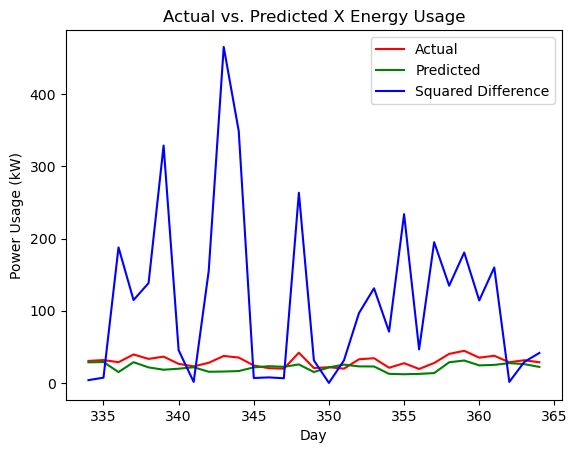

In [16]:
# Graph actual, predicted, and square difference data
plt.plot(df_compare['Actual'], color = 'r', label = 'Actual')
plt.plot(df_compare['Predicted'], color = 'g', label = 'Predicted')
plt.plot(df_compare['Squared Difference'], color = 'b', label = 'Squared Difference')
plt.xlabel("Day")
plt.ylabel("Power Usage (kW)")
plt.title("Actual vs. Predicted X Energy Usage")
plt.legend()
plt.show()

Now that the error has been analyzed, we create a csv dump to store all of the predicted energy usage values and their respective dates. First we deal with parsing the dates. Then divide the dates into unique dates and only choose dates in december. Lastly, add the predictions put into a dataframe earlier and create a csv dump.

In [17]:
# This is sample code to reveal what will be done to get day values
date_time = '2023-03-11 15:30:00'
day = date_time.split(" ")[0]
print(day)

2023-03-11


In [18]:
# Create a copy of the array and take the date out from the Date and Time, dropping the time
df_day = pd.DataFrame(df_energy.copy()['Date & Time'])
df_day['Days'] = df_day['Date & Time'].str.split().str.get(0)
df_day = df_day.drop(['Date & Time'], axis = 1)

# Now only show unique times
df_date = pd.DataFrame(df_day.copy()['Days'])
df_date['Date'] = pd.DataFrame(df_day['Days'].unique())
df_date = df_date.drop(['Days'], axis = 1)

# Now take only the days in december
df_december_energy_predictions = df_date.loc[334:364].copy()
df_december_energy_predictions.head(5)

,Date
334,2014-12-01
335,2014-12-02
336,2014-12-03
337,2014-12-04
338,2014-12-05


In [19]:
# Add the prediction values to the dataframe, print the table and create csv dump
df_december_energy_predictions['Predicted'] = y_pred.tolist()
print(df_december_energy_predictions)
cwd = os.getcwd()
path = cwd + "/energy_predictions.csv"
df_december_energy_predictions.to_csv(path, index=False)

           Date  Predicted
334  2014-12-01  28.573145
335  2014-12-02  29.038108
336  2014-12-03  15.067376
337  2014-12-04  28.766422
338  2014-12-05  21.579013
339  2014-12-06  18.333583
340  2014-12-07  19.745369
341  2014-12-08  21.809866
342  2014-12-09  15.507433
343  2014-12-10  15.845233
344  2014-12-11  16.504934
345  2014-12-12  21.589950
346  2014-12-13  23.233123
347  2014-12-14  22.372758
348  2014-12-15  25.678853
349  2014-12-16  15.125554
350  2014-12-17  21.565211
351  2014-12-18  25.433654
352  2014-12-19  22.962061
353  2014-12-20  22.843294
354  2014-12-21  12.627848
355  2014-12-22  12.067786
356  2014-12-23  12.571673
357  2014-12-24  13.714989
358  2014-12-25  28.658824
359  2014-12-26  31.118313
360  2014-12-27  24.352710
361  2014-12-28  25.044662
362  2014-12-29  27.463895
363  2014-12-30  26.113289
364  2014-12-31  22.223780


## Task 4: Logistic Regression: Temperature Classification

Using only weather data we want to classify if the temperature is high or low. Let's assume
temperature greater than or equal to 35 is ‘high’ and below 35 is ‘low’. Set up a logistic regression
model to classify the temperature for each day in the month of December. Calculate the F1 score
for the model.\
Finally generate a csv dump of the classification (1 for high, 0 for low)\
Format: Two columns, first should be the date and second should be the classification (1/0).\

First the dataframe has to be created including all of the daily weather data subsituting the values for temperature with a binary classification for it being a hot or cold day. The energy usage and time features will also be dropped.

In [20]:
# Create a daily weather dataframe that subsitutes temp double for hot/cold binary, also drops time
df_daily_weather = pd.DataFrame(df_daily.copy().drop(['use [kW]','time'], axis = 1))
df_daily_weather.loc[df_daily_weather['temperature'] >= 35, 'Hot/Cold'] = 1
df_daily_weather.loc[df_daily_weather['temperature'] < 35, 'Hot/Cold'] = 0
df_daily_weather['Hot/Cold'] = df_daily_weather['Hot/Cold'].astype(int)
df_daily_weather = df_daily_weather.drop('temperature', axis = 1)
df_daily_weather.head(10)

,humidity,visibility,pressure,windSpeed,cloudCover,windBearing,precipIntensity,dewPoint,precipProbability,icon,Hot/Cold
0,0.556667,9.970000,1025.395000,6.820417,0.031304,252.291667,0.000000,6.362083,0.000000,0,0
1,0.784583,3.834583,1023.465833,7.433750,0.354444,53.458333,0.002004,10.737083,0.074583,1,0
2,0.680833,4.509167,1014.428750,12.828333,0.186364,207.333333,0.002029,-2.337500,0.080000,1,0
3,0.617083,9.822917,1030.096250,5.248333,0.001667,240.166667,0.000000,-8.352083,0.000000,0,0
4,0.682083,9.134583,1025.275000,3.417083,0.010952,208.958333,0.000033,8.615000,0.000417,0,0
5,0.900417,4.062917,1003.460833,7.355833,1.000000,167.458333,0.026258,36.336250,0.460000,2,1
6,0.481250,9.784167,1009.740000,14.787083,0.014348,284.500000,0.000000,-2.297917,0.000000,0,0
7,0.504167,9.998750,1028.058333,7.298333,0.000833,228.750000,0.000000,-5.790417,0.000000,0,0
8,0.570833,9.967083,1033.970000,4.840833,0.016957,255.208333,0.000000,5.136667,0.000000,0,0
9,0.843750,7.059167,1033.154167,2.637500,0.160769,191.125000,0.001350,16.584583,0.054583,0,0


Now that the data is prepared, split the training and testing data so that a model can be trained to predict whether it will be hot or cold on each day in December. A logistic model will be used and the metrics for model performance will be displayed.

In [21]:
# Splitting 'df_daily_weather' into features and target
df_daily_weather_features = df_daily_weather.copy().drop('Hot/Cold', axis = 1)
df_daily_weather_target = df_daily_weather.copy()['Hot/Cold']

# Splitting data without randomization s.t. training data is only the last 31 days of the year (December)
X1_train, X1_test, y1_train, y1_test = train_test_split(df_daily_weather_features, df_daily_weather_target, 
                                                  test_size=31/365, shuffle = False, stratify = None)

In [22]:
# Create the linear regression model and fit to training data
log_reg = LogisticRegression()
log_reg.fit(X1_train, y1_train)

LogisticRegression()

In [23]:
# Predict the energy usage values for the month of December and find performance metric
y1_pred = log_reg.predict(X1_test)
log_f = metric.f1_score(y1_test, y1_pred)

# Put metrics in dataframe and display
print("F-Score: {}".format(log_f))

F-Score: 0.6842105263157895


This F-Score is mediocre revealing that the features described in the data are not the greatest indicators of whether the day will be hot or cold, but they are farely decent considering the harsh requirements of the F-Score metric. Finally a csv dump will be created showing the predictions.

In [24]:
df_december_temp_predictions = pd.DataFrame(df_december_energy_predictions['Date'].copy())
df_december_temp_predictions['Predicted'] = y1_pred.tolist()
print(df_december_temp_predictions)
cwd = os.getcwd()
path = cwd + "/temperature_predictions.csv"
df_december_temp_predictions.to_csv(path, index=False)

           Date  Predicted
334  2014-12-01          1
335  2014-12-02          1
336  2014-12-03          1
337  2014-12-04          1
338  2014-12-05          0
339  2014-12-06          1
340  2014-12-07          1
341  2014-12-08          0
342  2014-12-09          1
343  2014-12-10          1
344  2014-12-11          0
345  2014-12-12          1
346  2014-12-13          1
347  2014-12-14          1
348  2014-12-15          1
349  2014-12-16          1
350  2014-12-17          1
351  2014-12-18          1
352  2014-12-19          1
353  2014-12-20          0
354  2014-12-21          1
355  2014-12-22          1
356  2014-12-23          1
357  2014-12-24          1
358  2014-12-25          1
359  2014-12-26          1
360  2014-12-27          1
361  2014-12-28          1
362  2014-12-29          1
363  2014-12-30          0
364  2014-12-31          0


## Task 5: Enery Usage Data Analysis

We want to analyze how different devices are being used in different times of the day.
- Is the washer being used only during the day?
- During what time of the day is AC used most?

There are a number of questions that can be asked.
For simplicity, let’s divide a day in two parts:
- Day: 6AM - 7PM
- Night: 7PM - 6AM

Analyze the usage of any two devices of your choice during the ‘day’ and ‘night’. Plot these
trends. Explain your findings.

In order to analyze what devices are used at night and during the data, the "Date & Time" feature must be manipulated in order to label entries as either night or day. The first step is to convert the "Date & Time" feature into an "Hour" feature, which is simply a float giving the hour it is in the day (e.g. 4:30:00 ---> 4.5). First the general process is outlined with an example time and date and then it is applied to the dataframe.

In [25]:
# This is sample code to reveal what will be done to get hour values
date_time = '2023-03-11 15:30:00'
time = date_time.split(" ")[1]
print(time)
hour = float(time.split(":")[0]) + float(time.split(":")[1]) / 60
print(hour)

15:30:00
15.5


In [26]:
# Create a copy of the array and take the time out from the Date and Time, dropping the date
df_energy_split = df_energy.copy()
df_energy_split['Time'] = df_energy_split['Date & Time'].str.split().str.get(1)
df_energy_split = df_energy_split.drop(['Date & Time'], axis = 1)
df_energy_split.head(5)

,use [kW],gen [kW],Grid [kW],AC [kW],Furnace [kW],Cellar Lights [kW],Washer [kW],First Floor lights [kW],Utility Rm + Basement Bath [kW],Garage outlets [kW],MBed + KBed outlets [kW],Dryer + egauge [kW],Panel GFI (central vac) [kW],Home Office (R) [kW],Dining room (R) [kW],Microwave (R) [kW],Fridge (R) [kW],Time
0,0.304439,0.0,0.304439,0.000058,0.009531,0.005336,0.000126,0.011175,0.003836,0.004836,0.002132,0.000009,0.007159,0.063666,0.004299,0.004733,0.042589,00:00:00
1,0.656771,0.0,0.656771,0.001534,0.364338,0.005522,0.000043,0.003514,0.003512,0.004888,0.002137,0.000107,0.007221,0.064698,0.003589,0.004445,0.096008,00:30:00
2,0.612895,0.0,0.612895,0.001847,0.417989,0.005504,0.000044,0.003528,0.003484,0.004929,0.002052,0.000170,0.007197,0.065109,0.003522,0.004396,0.025928,01:00:00
3,0.683979,0.0,0.683979,0.001744,0.410653,0.005556,0.000059,0.003499,0.003476,0.004911,0.002068,0.000121,0.007236,0.065032,0.003404,0.004262,0.105472,01:30:00
4,0.197809,0.0,0.197809,0.000030,0.017152,0.005302,0.000119,0.003694,0.003865,0.004876,0.002087,0.000052,0.007133,0.062451,0.003915,0.004407,0.016798,02:00:00


In [27]:
# Convert the time to a float of the hour depending on the time in hours and minutes, drop time
df_energy_split['Hour'] = pd.to_numeric(df_energy_split['Time'].str.split(":").str.get(0), errors = 'coerce')  + \
                            pd.to_numeric(df_energy_split['Time'].str.split(":").str.get(1), errors = 'coerce') / 60
df_energy_split = df_energy_split.drop(['Time'], axis = 1)
df_energy_split.head(5)   

,use [kW],gen [kW],Grid [kW],AC [kW],Furnace [kW],Cellar Lights [kW],Washer [kW],First Floor lights [kW],Utility Rm + Basement Bath [kW],Garage outlets [kW],MBed + KBed outlets [kW],Dryer + egauge [kW],Panel GFI (central vac) [kW],Home Office (R) [kW],Dining room (R) [kW],Microwave (R) [kW],Fridge (R) [kW],Hour
0,0.304439,0.0,0.304439,0.000058,0.009531,0.005336,0.000126,0.011175,0.003836,0.004836,0.002132,0.000009,0.007159,0.063666,0.004299,0.004733,0.042589,0.0
1,0.656771,0.0,0.656771,0.001534,0.364338,0.005522,0.000043,0.003514,0.003512,0.004888,0.002137,0.000107,0.007221,0.064698,0.003589,0.004445,0.096008,0.5
2,0.612895,0.0,0.612895,0.001847,0.417989,0.005504,0.000044,0.003528,0.003484,0.004929,0.002052,0.000170,0.007197,0.065109,0.003522,0.004396,0.025928,1.0
3,0.683979,0.0,0.683979,0.001744,0.410653,0.005556,0.000059,0.003499,0.003476,0.004911,0.002068,0.000121,0.007236,0.065032,0.003404,0.004262,0.105472,1.5
4,0.197809,0.0,0.197809,0.000030,0.017152,0.005302,0.000119,0.003694,0.003865,0.004876,0.002087,0.000052,0.007133,0.062451,0.003915,0.004407,0.016798,2.0


Now that the hour value has been found for each entry, these values will simply be used to cagetorize each group into a "Day/Night" feature to be divided for further analysis.

In [28]:
# Now using the 'Hour' feature create a 'Day/Night' Feature
df_energy_split.loc[(df_energy_split['Hour'] >= 6) & (df_energy_split['Hour'] < 17), 'Day/Night'] = 'Day'
df_energy_split.loc[(df_energy_split['Hour'] >= 17) | (df_energy_split['Hour'] < 6), 'Day/Night'] = 'Night'
df_energy_split = df_energy_split.drop(['Hour'], axis = 1)
df_energy_split.head(48)

,use [kW],gen [kW],Grid [kW],AC [kW],Furnace [kW],Cellar Lights [kW],Washer [kW],First Floor lights [kW],Utility Rm + Basement Bath [kW],Garage outlets [kW],MBed + KBed outlets [kW],Dryer + egauge [kW],Panel GFI (central vac) [kW],Home Office (R) [kW],Dining room (R) [kW],Microwave (R) [kW],Fridge (R) [kW],Day/Night
0,0.304439,0.0,0.304439,0.000058,0.009531,0.005336,0.000126,0.011175,0.003836,0.004836,0.002132,0.000009,0.007159,0.063666,0.004299,0.004733,0.042589,Night
1,0.656771,0.0,0.656771,0.001534,0.364338,0.005522,0.000043,0.003514,0.003512,0.004888,0.002137,0.000107,0.007221,0.064698,0.003589,0.004445,0.096008,Night
2,0.612895,0.0,0.612895,0.001847,0.417989,0.005504,0.000044,0.003528,0.003484,0.004929,0.002052,0.000170,0.007197,0.065109,0.003522,0.004396,0.025928,Night
3,0.683979,0.0,0.683979,0.001744,0.410653,0.005556,0.000059,0.003499,0.003476,0.004911,0.002068,0.000121,0.007236,0.065032,0.003404,0.004262,0.105472,Night
4,0.197809,0.0,0.197809,0.000030,0.017152,0.005302,0.000119,0.003694,0.003865,0.004876,0.002087,0.000052,0.007133,0.062451,0.003915,0.004407,0.016798,Night
5,0.397099,0.0,0.397099,0.000442,0.126960,0.005415,0.000054,0.003627,0.003749,0.004891,0.002133,0.000024,0.007187,0.063814,0.003813,0.004398,0.106717,Night
6,0.590319,0.0,0.590319,0.001858,0.420358,0.005509,0.000043,0.003562,0.003541,0.005007,0.002072,0.000197,0.007208,0.065277,0.003008,0.004008,0.006479,Night
7,0.538266,0.0,0.538266,0.001071,0.257654,0.005507,0.000020,0.003582,0.003549,0.004837,0.002136,0.000047,0.007198,0.063142,0.004142,0.004565,0.121088,Night
8,0.189187,0.0,0.189187,0.000056,0.009462,0.005302,0.000141,0.003708,0.003837,0.004858,0.002086,0.000034,0.007107,0.070109,0.004202,0.004704,0.011131,Night
9,0.653232,0.0,0.653232,0.001663,0.387637,0.005552,0.000033,0.003532,0.003463,0.004878,0.002112,0.000118,0.007203,0.064450,0.003669,0.004194,0.104737,Night


Now that the data can now be grouped based on whether it is night or day, average usage of certain devices during night and day can be analyzed. First we will analyze the two examples provided by the problem, taking note of the usage of washers and air conditioning during the day and night.

Text(0, 0.5, 'Washer Power Consumption (kW)')

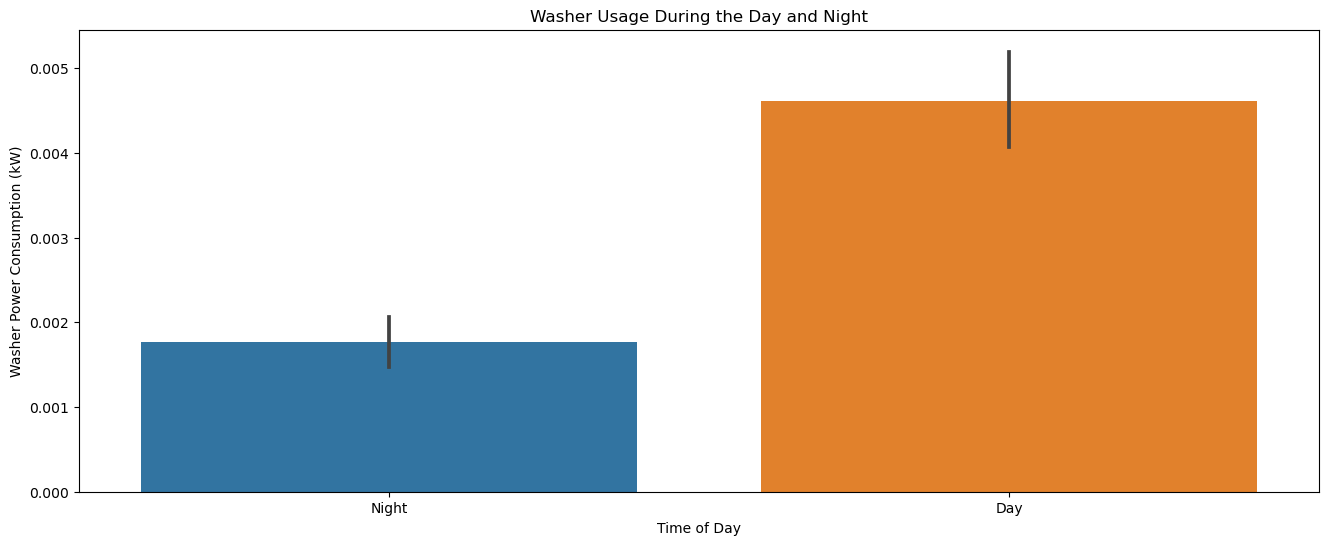

In [29]:
# Plotting the average washer power draw during the day and night
plt.figure(figsize=(16, 6))
family_sex_graph = sns.barplot(data=df_energy_split, x="Day/Night", y="Washer [kW]")
family_sex_graph.set_title('Washer Usage During the Day and Night')
family_sex_graph.set_xlabel('Time of Day')
family_sex_graph.set_ylabel('Washer Power Consumption (kW)')

Text(0, 0.5, 'AC Power Consumption (kW)')

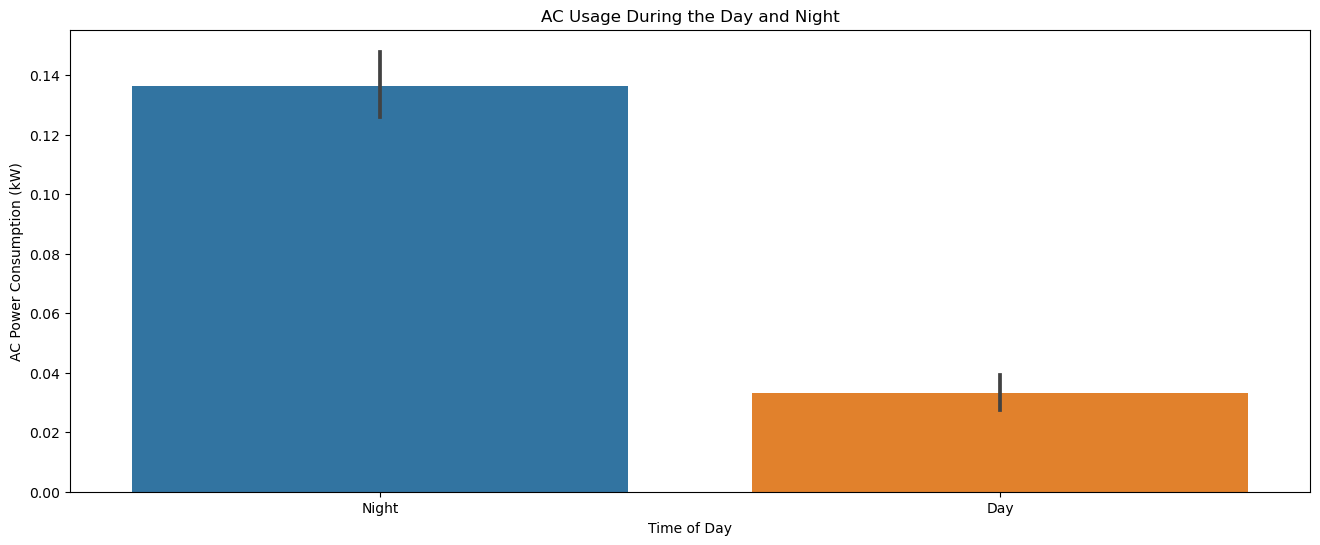

In [30]:
# Plotting the average AC power draw during the day and night
plt.figure(figsize=(16, 6))
family_sex_graph = sns.barplot(data=df_energy_split, x="Day/Night", y="AC [kW]")
family_sex_graph.set_title('AC Usage During the Day and Night')
family_sex_graph.set_xlabel('Time of Day')
family_sex_graph.set_ylabel('AC Power Consumption (kW)')

As seen above, the washers were used significantly more during the day as is expected as people don't typically put clothes in the wash during the night. However, the results for AC usage are interesting since it is mostly used during the night when it is cooler. This may be because people are less likely to be in the house during the day so they only run the AC when they are home at night.

Now we investigate two more devices of interest, starting with the dryer usage to see if a relationship can be built with the washer.

Text(0, 0.5, 'Dryer Power Consumption (kW)')

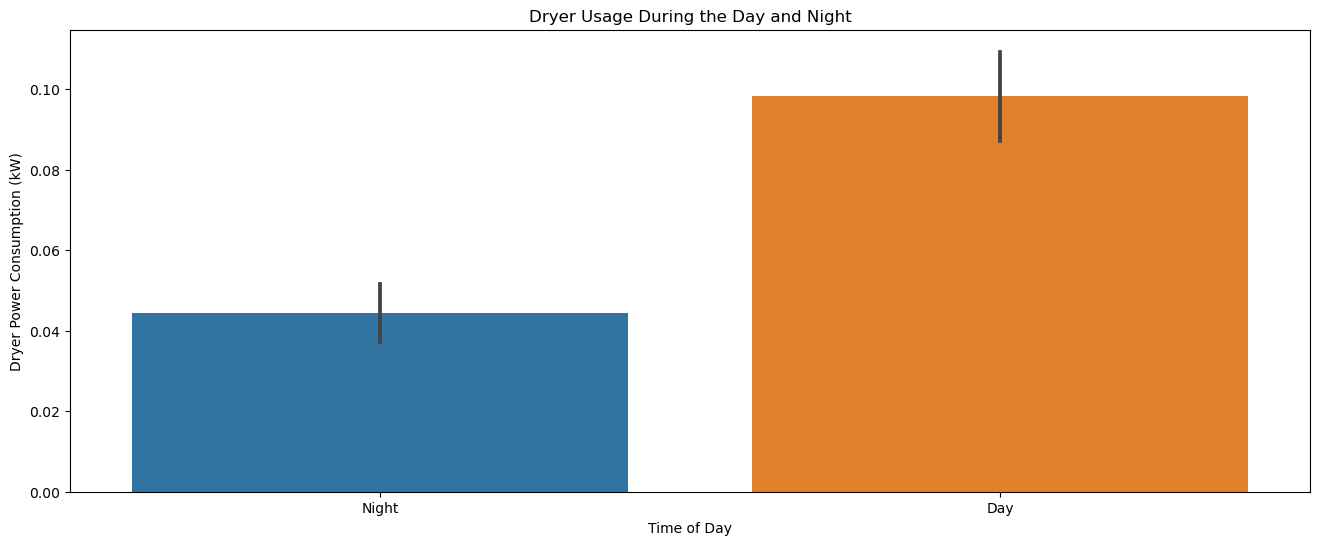

In [31]:
# Plotting the average dryer power draw during the day and night
plt.figure(figsize=(16, 6))
family_sex_graph = sns.barplot(data=df_energy_split, x="Day/Night", y="Dryer + egauge [kW]")
family_sex_graph.set_title('Dryer Usage During the Day and Night')
family_sex_graph.set_xlabel('Time of Day')
family_sex_graph.set_ylabel('Dryer Power Consumption (kW)')

As we can see, the relative night and day power usage of the dryer is very comparable to the usage for the dryer. This of course makes sense as after the washer is used the dryer will logically be used next, and chances are these features are likely correlated.

Text(0, 0.5, 'Microwave Power Consumption (kW)')

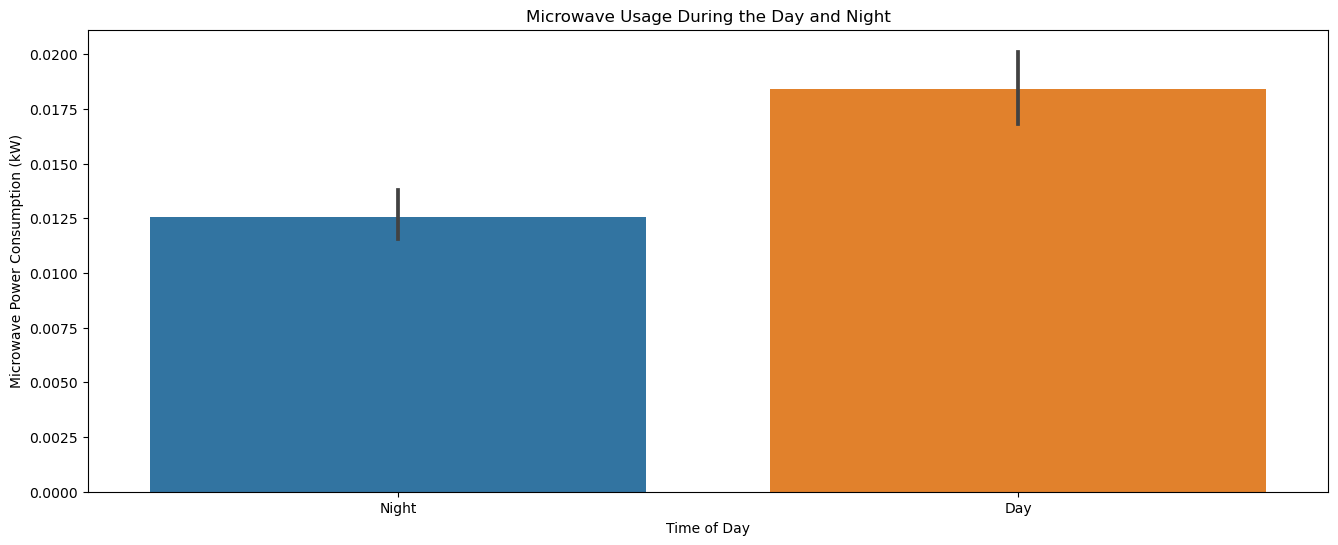

In [32]:
# Plotting the average microwave power draw during the day and night
plt.figure(figsize=(16, 6))
family_sex_graph = sns.barplot(data=df_energy_split, x="Day/Night", y="Microwave (R) [kW]")
family_sex_graph.set_title('Microwave Usage During the Day and Night')
family_sex_graph.set_xlabel('Time of Day')
family_sex_graph.set_ylabel('Microwave Power Consumption (kW)')

Unlike the previous three devices, the microwave does not vary as much when it comes to the time of day. While it makes sense that the microwave is used mostly during the day hours which is when people normally eat, it also makes sense that it would be used during the night as it is likely used more for late night cravings.